This notebook is for an interactive workshop on using Python for image analysis - with the Seam Carving algorithm as an example. We'll start out with some setup and background to show everyone that images are simply arrays of numbers that can be manipulated like any other data. Then we'll do a quick demonstration of the Seam Carving algorithm which uses pixelwise calculations to stealthily resize images.

For more seam_carving with Python, you may want to investigate scikit-image and its built-in seam carving functionality:<br> http://scikit-image.org/docs/dev/auto_examples/transform/plot_seam_carving.html

Here, we implement seam carving with ony the most standard scientific python libraries to show the pixelwise manipulation that is so powerful to be used in all kinds of applications.

Author: Rebecca Perry, reperry@wayfair.com
Created: January, 2018

# 1. Setup

Check that Matplotlib imports correctly by making a plot. Click into the first "cell" and then type shift-enter to run the code in that cell.

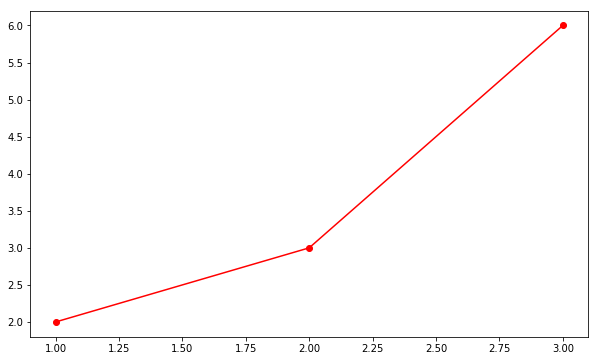

In [1]:
%matplotlib inline

import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import seamcarving #separate .py file supplied alongside this notebook

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot([1,2,3],[2,3,6],'-ro')

Exercise 1: 

Check that scipy.misc imported correctly by reading and displaying an image. To load the image, you will need to correct the file path to match the file structure on your computer. 

(Products in image found at https://www.wayfair.com/finds !)

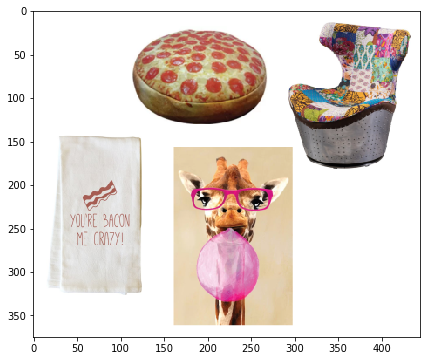

In [2]:
imfilepath = r'/home/becca/Documents/teaching/python_seam_carving/finds.png'
im = scipy.misc.imread(imfilepath)
plt.imshow(im)

# 2. The Contents of a Digital Image

A very brief overview of Python data types before an introduction to what the guts of a digital image look like.

In [ ]:
#integer vs. float
mynumber = 8
print(mynumber)
type(mynumber)

In [ ]:
myothernumber = 8.0
print(myothernumber)
type(myothernumber)

In [ ]:
#lists and slicing
mylist = [5,6,7,'banana']
print(mylist)
print(mylist[2])
print(mylist[1:3])
print(mylist[1:])
print(mylist[:2])
type(mylist)

Exercise 2: 
    
Use the following cell to slice into mylist to return the last two values of the list.

In [ ]:
#numpy arrays
myarray = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(myarray)

In [ ]:
plt.imshow(myarray)
plt.gray()
plt.colorbar()
plt.title('A 3x3 Array Displayed as an Image')

In [ ]:
im = scipy.misc.imread(imfilepath)
plt.imshow(im)

In [ ]:
print(type(im))
print(np.shape(im))
print(type(im[0,0,0]))
print('Image array min: {0}\nImage array max: {1}'.format(np.min(im),np.max(im)))

The image is an array of unsigned 8-bit integers with values ranging from 0 to 255. The image is 375 pixels high and 445 pixels wide. Each pixel has three values for the amount of red, green, and blue in the color at that pixel.

In [ ]:
#see the pixel values in a section of the image
#to index into this color image, use three values or ranges of values: 
#rows, columns, and colors (in that order)
print(im[50:100,350:400,:])
plt.imshow(im[50:100,350:400,:],interpolation='None')

In [ ]:
#Show the red, green, and blue channels of the image
blank = np.zeros(np.shape(im)).astype(np.uint8)

plt.figure(figsize=[20,20])

plt.subplot(1,3,1)
red = np.copy(blank)
red[:,:,0] = im[:,:,0]
plt.imshow(red)

plt.subplot(1,3,2)
green = np.copy(blank)
green[:,:,1]=im[:,:,1]
plt.imshow(green)

plt.subplot(1,3,3)
blue = np.copy(blank)
blue[:,:,2]=im[:,:,2]
plt.imshow(blue)

In [ ]:
#how does it look if we combine two of the three colors?
bluegreen = np.copy(blank)
bluegreen[:,:,1]=im[:,:,1]
bluegreen[:,:,2]=im[:,:,2]
plt.imshow(bluegreen)

In [ ]:
#recover the original image by setting the red, green, and blue channels 
#the new image to the red, green, and blue channels in the original
allcolors = np.copy(blank)
allcolors[:,:,0]=im[:,:,0]
allcolors[:,:,1]=im[:,:,1]
allcolors[:,:,2]=im[:,:,2]
plt.imshow(allcolors)

Exercise 3: 

Check for understanding: Make one 200x200 pixel image that is entirely black, another that is entirely white, and a third that is half one color and half another color.

Need RGB values? http://htmlcolorcodes.com/

A digital image is simply an array of data that we can perform operations on like any other data. When viewed this way, you can come up with many clever image manipulations!

# 3. Seam Carving Components

Seam carving is a clever algorithm for reshaping images by removing the least interesting pixels. This could be useful for showing the same image on screens with different aspect ratios. Instead of removing whole columns from the image, we find and remove optimal single-pixel-wide paths running from the top of the image to the bottom of the image.

Original seam carving paper: Shai Avidan and Ariel Shamir, 2007 graphics.cs.cmu.edu/courses/15-463/2007_fall/hw/proj2/imret.pdf

In [ ]:
#load in a fresh copy of the image
im = scipy.misc.imread(imfilepath)
plt.imshow(im)
np.shape(im)

In [ ]:
# cropping columns from one side results in lost content
plt.imshow(im[:,:400,:])

In [ ]:
#resizing image results in distorted products
narrow = scipy.misc.imresize(im, [375,400,3])
plt.imshow(narrow)

And now, the seam carving approach! This involves 4 steps to make the image narrower by 1 pixel-width:

(1) Calculating how interesting each pixel is: this is the "energy" of each pixel<br>
(2) Calculating the sum of the energy along paths that connect the top and bottom of the image<br>
(3) Identify the path that collects the least energy<br>
(4) Remove the pixels along this selected path from the image<br>

In [ ]:
# (1) calculate how interesting each pixel is: the "energy" of each pixel

# convert the color image into grayscale by adding the three color
# layers together
gray = np.sum(im,axis=2)

# I am defining the energy as the difference between a pixel and 
# its 4 neighbors, could also use edge detection (e.g. Sobel)
energy = np.copy(gray)
energy[1:-1,1:-1] = (abs(gray[1:-1,1:-1]-gray[:-2,1:-1])+
                     abs(gray[1:-1,1:-1]-gray[2:,1:-1])+
                     abs(gray[1:-1,1:-1]-gray[1:-1,:-2])+
                     abs(gray[1:-1,1:-1]-gray[1:-1,2:]))
#treat last row of energy separately
energy[-1,1:-1] = (abs(gray[-1,1:-1]-gray[-2,1:-1])+
                     abs(gray[-1,1:-1]-gray[-1,:-2])+
                     abs(gray[-1,1:-1]-gray[-1,2:]))
#NOTE: ignoring top row and left and right edges for now

plt.imshow(energy.astype(np.uint8))
plt.jet()

In [ ]:
#(2) calculate the cumulative energy you collect by following a path
# from the top to the bottom of the image. At each pixel, show the 
# minimum value of cumulative energy to get there.
energypaths = np.zeros(np.shape(gray))
energypaths[0,:] = energy[0,:]

num_rows, num_cols = np.shape(gray)

for row in range(1,num_rows):
    for col in range(num_cols):
        if col==0:
            energypaths[row,col] = (energy[row,col]+
                                   min(energypaths[row-1,:2]))
        elif col==num_cols-1:
            energypaths[row,col] = (energy[row,col]+
                                    min(energypaths[row-1,col-1:num_cols]))
        else:
            energypaths[row,col] = (energy[row,col]+
                                    min(energypaths[row-1,col-1:col+2]))
            
plt.imshow(energypaths)
plt.title('Brighter Colors are more "Interesting" pars of the Image')

In [ ]:
#(3) find the seam running from top edge to bottom edge with the lowest energy

#start at the bottom to find the smallest value of accumulated energy
minima = np.where(energypaths[-1,:]==energypaths[-1,:].min())[0]
#settle ties among multiple equivalent minima by choosing randomly
minimum = np.random.choice(minima)

#for each row above the bottom one, determine the matching column value
colvals = np.zeros(num_rows).astype(int)
colvals[-1] = minimum

for row in np.arange(num_rows-2,-1,-1):
    prevcol = colvals[row+1]
    if prevcol!=0 and prevcol!=num_cols-1:
        if (energypaths[row,prevcol-1]<energypaths[row,prevcol] and 
           energypaths[row,prevcol-1]<energypaths[row,prevcol+1]):
            colvals[row] = prevcol-1
        elif (energypaths[row,prevcol+1]<energypaths[row,prevcol-1] and 
              energypaths[row,prevcol+1]<energypaths[row,prevcol]):
            colvals[row] = prevcol+1
        else:
            colvals[row] = prevcol  
    if prevcol==0:
        if energypaths[row,prevcol]<=energypaths[row,prevcol+1]:
            colvals[row] = prevcol    
        else:
            colvals[row] = prevcol+1
    if prevcol==num_cols-1:
        if energypaths[row,prevcol]<=energypaths[row,prevcol-1]:
            colvals[row] = prevcol    
        else:
            colvals[row] = prevcol-1

In [ ]:
#show the seam to be removed
seamdisplay = np.copy(im)

seamdisplay[range(num_rows),colvals,:]=[255,0,0]
if colvals.min()>0:
    seamdisplay[range(num_rows),colvals-1,:]=[255,0,0]
if colvals.max()<num_cols-2:
    seamdisplay[range(num_rows),colvals+1,:]=[255,0,0]

plt.figure(figsize=(12,12))
plt.imshow(seamdisplay[:,:])

In [ ]:
smallerim = seamcarving.removeseam(im,colvals)
np.shape(smallerim)
plt.imshow(smallerim)
print('Starting image size: {0}'.format(np.shape(seamdisplay)))
print('Resulting image size: {0}'.format(np.shape(smallerim)))

# 4. Reusing the code to substantially resize images

In [9]:
original = scipy.misc.imread(r'/home/becca/Documents/teaching/python_seam_carving/finds.png')
workingim = np.copy(original)
for i in range(60):
    seam, energypaths = seamcarving.findseam(workingim)
    workingim = seamcarving.removeseam(workingim,seam)

Starting image size: (375, 445, 3)
Resulting image size: (375, 385, 3)


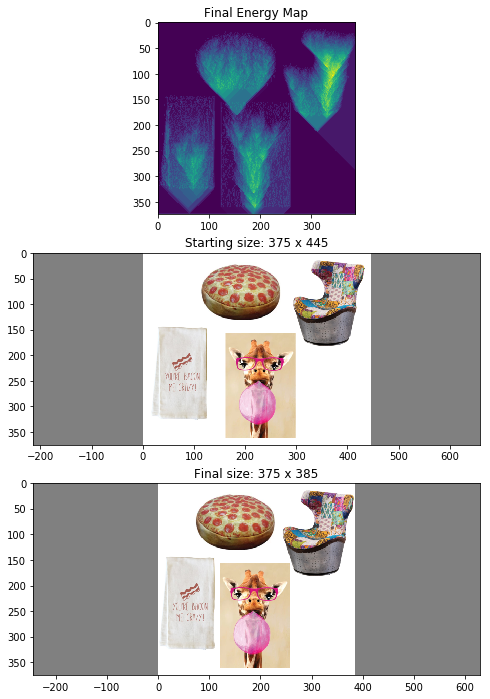

In [10]:
fig = plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.imshow(energypaths)
plt.title('Final Energy Map')

axes = plt.subplot(3,1,2,facecolor='gray')
plt.imshow(original)
plt.title('Starting size: {0} x {1}'.format(np.shape(original)[0],
                                            np.shape(original)[1]))
plt.axis('equal')

plt.subplot(3,1,3,facecolor='gray')
plt.imshow(workingim)
plt.title('Final size: {0} x {1}'.format(np.shape(workingim)[0],
                                         np.shape(workingim)[1]))
plt.axis('equal')

print('Starting image size: {0}'.format(np.shape(original)))
print('Resulting image size: {0}'.format(np.shape(workingim)))

Exercise 4:<br>
Try another image! Remember to edit the file path to direct to the image on your computer. What are the results like when you remove different numbers of paths?

In [4]:
#Image attribution: By Getfunky Paris (Flickr) [CC BY 2.0 (http://creativecommons.org/licenses/by/2.0)], via Wikimedia Commons
#https://commons.wikimedia.org/wiki/File%3AEiffel_Tower_and_Pont_Alexandre_III_at_night.jpg

original = scipy.misc.imread(r'/home/becca/Documents/teaching/python_seam_carving/Eiffel_Tower_and_Pont_Alexandre_III_at_night.jpg')
workingim = np.copy(original)
paths = 50

for i in range(paths):
    seam, energypaths = seamcarving.findseam(workingim)
    workingim = seamcarving.removeseam(workingim,seam)

Starting image size: (328, 512, 3)
Resulting image size: (328, 462, 3)


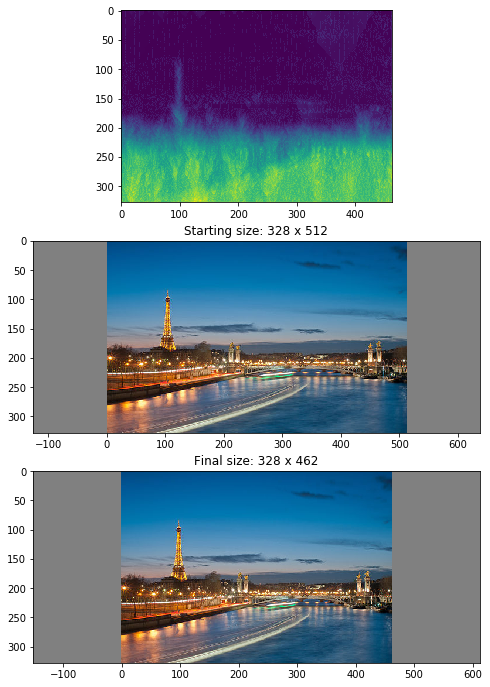

In [7]:
fig = plt.figure(figsize=(8,12))
plt.subplot(3,1,1)
plt.imshow(energypaths)

axes = plt.subplot(3,1,2,facecolor='gray')
plt.imshow(original)
plt.title('Starting size: {0} x {1}'.format(np.shape(original)[0],np.shape(original)[1]))
plt.axis('equal')

plt.subplot(3,1,3,facecolor='gray')
plt.imshow(workingim)
plt.title('Final size: {0} x {1}'.format(np.shape(workingim)[0],np.shape(workingim)[1]))
plt.axis('equal')

print('Starting image size: {0}'.format(np.shape(original)))
print('Resulting image size: {0}'.format(np.shape(workingim)))

You have now seam-carved some images! This workshop introduced the structure of most digital images: RGB values per pixel and then showed an example of how you can use those values to inform a clever manipulation of images. What other manipulations would you like to do with the RGB values or grayscale values as input?

Questions? Please feel free to contact me at:
reperry@wayfair.com